In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
import torch.nn.functional as F
from torchinfo import summary
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action="ignore")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("NVIDIA GPU available, running stuff on GPU" if DEVICE.type == "cuda" else "No NVIDIA GPU available, running stuff on CPU")

NVIDIA GPU available, running stuff on GPU


In [2]:
ROOT_DIR = r"C:\Users\delga\Documents\programming\datasets"

train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])  #Known metrics from CIFAR10
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])   #Known metrics from CIFAR10
])

full_train_dataset = datasets.CIFAR10(
    root=ROOT_DIR, 
    download=False, 
    train=True, 
    transform=train_transforms
    )

train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(
    dataset=full_train_dataset,
    lengths=[train_size, val_size],
    generator=torch.Generator().manual_seed(22)
)

val_dataset.dataset.transform = val_transforms      # Replace val transform (so validation doesn't use augmentations)

test_dataset = datasets.CIFAR10(
    root=ROOT_DIR, 
    download=False, 
    train=False, 
    transform=val_transforms
    )

print(f"\nCompleted data loading and splits:\n * Train dataset: {len(train_dataset)} samples\n * Validation dataset: {len(val_dataset)} samples\n * Test dataset: {len(test_dataset)} samples")

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True, num_workers=1, pin_memory=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=128, shuffle=True, num_workers=1, pin_memory=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=True, num_workers=1, pin_memory=True)


Completed data loading and splits:
 * Train dataset: 45000 samples
 * Validation dataset: 5000 samples
 * Test dataset: 10000 samples


In [3]:
# indices = torch.arange(100)
# tiny_train_dataset = Subset(dataset=train_dataset, indices=indices)
# tiny_loader = DataLoader(dataset=tiny_train_dataset, batch_size=16, shuffle=True)
# images, labels = next(iter(tiny_loader))
# print(images.shape, labels.shape)

In [4]:
class CNN(nn.Module):
    """
    A simple Convolutional Neural Network for CIFAR-10 classification.
    Input: 3x32x32 images
    Output: 10 class logits
    """
    def __init__(self) -> None:
        super(CNN, self).__init__()
        # --- Convolutional layers ---
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # --- Batch Normalization layers + Pooling layer ---
        self.bn1 = nn.BatchNorm2d(num_features=32)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # --- Fully Connected layers ---
        self.fc1 = nn.Linear(in_features=64 * 8 * 8, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=10)  # 10 CIFAR-10 classes
        # --- Regularization ---
        self.dropout = nn.Dropout(p=0.25)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.bn1(self.conv1(x))))   # Output: [B, 32, 16, 16]
        x = self.pool(F.relu(self.bn2(self.conv2(x))))   # Output: [B, 64, 8, 8]
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [5]:
model = CNN().to(DEVICE)
# images, labels = next(iter(tiny_loader))
# images, labels = images.to(device), labels.to(device)
# out = model(images)
# print(out.shape)
summary(model, input_size=(16, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [16, 10]                  --
├─Conv2d: 1-1                            [16, 32, 32, 32]          896
├─BatchNorm2d: 1-2                       [16, 32, 32, 32]          64
├─MaxPool2d: 1-3                         [16, 32, 16, 16]          --
├─Conv2d: 1-4                            [16, 64, 16, 16]          18,496
├─BatchNorm2d: 1-5                       [16, 64, 16, 16]          128
├─MaxPool2d: 1-6                         [16, 64, 8, 8]            --
├─Linear: 1-7                            [16, 256]                 1,048,832
├─Dropout: 1-8                           [16, 256]                 --
├─Linear: 1-9                            [16, 10]                  2,570
Total params: 1,070,986
Trainable params: 1,070,986
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 107.27
Input size (MB): 0.20
Forward/backward pass size (MB): 12.62
Params size (MB): 4.28
Estimat

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

def train_and_validate(model, train_loader, val_loader, epochs, criterion, optimizer):
    """
    Trains the model {epochs} number of times, within each epoch it
    trains the whole data inside the loader and later evaluates it using
    the validation loader
    """
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(epochs):
        # --- Training phase ---
        model.train()
        total_train_loss = 0
        
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # --- Evaluation phase ---
        model.eval()
        total_val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
                
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch [{epoch+1}/{epochs}] | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Val Acc: {val_accuracy:.2f}%")
    
    # --- Plotting the curves ---    
    epochs_range = range(1, epochs + 1)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label="Train Loss")
    plt.plot(epochs_range, val_losses, label="Validation Loss")
    plt.title("Loss Curves")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, val_accuracies, label="Validation Accuracy", color="green")
    plt.title("Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return train_losses, val_losses, val_accuracies
          
        
def test_loop(model, data_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    accuracy = 100 * correct / total
    print(f"\nTest Accuracy: {accuracy:.2f}%")
    return accuracy

Epoch [1/10] | Train Loss: 0.2046 | Val Loss: 1.0551 | Val Acc: 75.14%
Epoch [2/10] | Train Loss: 0.1959 | Val Loss: 1.0881 | Val Acc: 74.64%
Epoch [3/10] | Train Loss: 0.1903 | Val Loss: 1.0940 | Val Acc: 74.90%
Epoch [4/10] | Train Loss: 0.1846 | Val Loss: 1.1106 | Val Acc: 75.08%
Epoch [5/10] | Train Loss: 0.1785 | Val Loss: 1.1028 | Val Acc: 75.38%
Epoch [6/10] | Train Loss: 0.1712 | Val Loss: 1.1248 | Val Acc: 74.46%
Epoch [7/10] | Train Loss: 0.1782 | Val Loss: 1.1710 | Val Acc: 74.36%
Epoch [8/10] | Train Loss: 0.1697 | Val Loss: 1.0586 | Val Acc: 74.64%
Epoch [9/10] | Train Loss: 0.1699 | Val Loss: 1.1405 | Val Acc: 74.06%
Epoch [10/10] | Train Loss: 0.1631 | Val Loss: 1.1722 | Val Acc: 74.66%


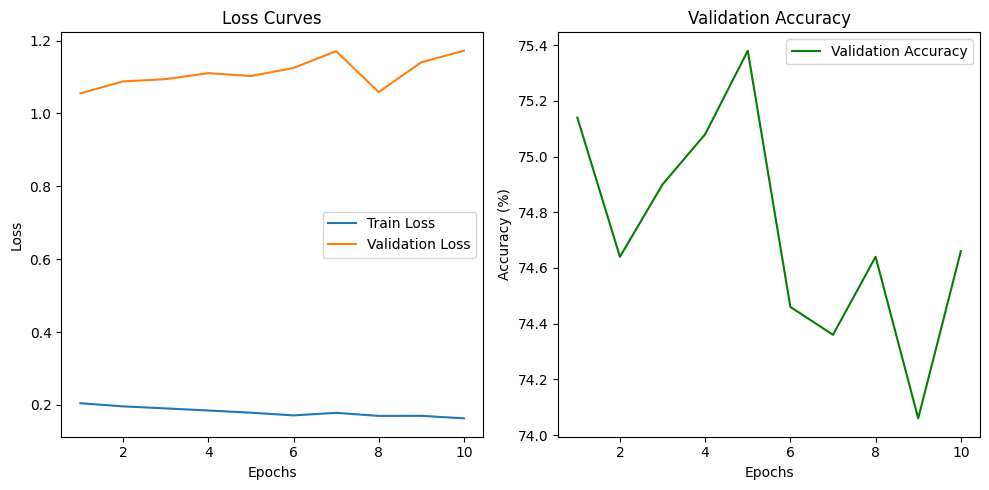


Test Accuracy: 74.84%


74.84

In [13]:
train_and_validate(model=model, train_loader=train_loader, val_loader=val_loader, epochs=10, criterion=criterion, optimizer=optimizer)  
test_loop(model=model, data_loader=test_loader)